<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тестирование моделей</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загружаем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import re 
import spacy
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
#from time import time
#import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load
from scipy.sparse import hstack

import nltk
from nltk.corpus import stopwords as nltk_stopwords

### Анализ данных

Загружаем и изучаем данные.

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Посмотрим на объекты с положительным таргетом.

In [3]:
df[df['toxic']==1].head()

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


Посмотрим пропуски.

In [4]:
df.isna().mean()

text     0.0
toxic    0.0
dtype: float64

Среди небольшой просмотренной выборки заметно, что комментарии написанные в верхнем регистре имеют положительный целевой признак. В дальнейшем добавим признак, если текст написан в верхнем регистре.

Баланс классов целевого признака.

0    143346
1     16225
Name: toxic, dtype: int64

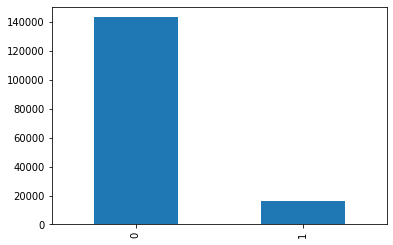

In [5]:
df['toxic'].value_counts().plot(kind='bar')
df['toxic'].value_counts()

In [6]:
df.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


- В тексте имеются символы разметки, другие символы кроме буквенных и разный регистр текста.
- Присутствует дисбаланс классов.

Функция очищения текста от посторонних символов.

In [7]:
def clear_text(row):
    row = re.sub(r"(?:\n|\r)", " ", row)
    row = re.sub(r"[^a-zA-Z ]+", "", row).strip()
    return row

In [8]:
df['text_clean'] = df['text'].apply(clear_text)

In [9]:
df.head()

,text,toxic,text_clean
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


Фукнция возвращения единицы, если текст написан полностью в вехнем регистре, и нуля во вех остальных случаях.

In [10]:
def caps_text(row):
    if row == re.sub(r"[^A-Z ]+", "", row):
        caps=1
    else:
        caps=0 
    return caps

In [11]:
df['caps_on'] = df['text_clean'].apply(caps_text)

In [12]:
df[df['toxic']==1].head()

,text,toxic,text_clean,caps_on
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,Hey what is it talk What is it an exclusive...,0
16,"Bye! \n\nDon't look, come or think of comming ...",1,Bye Dont look come or think of comming back ...,0
42,You are gay or antisemmitian? \n\nArchangel WH...,1,You are gay or antisemmitian Archangel WHite...,0
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,1


Посмотрим на среднее значение целевого признака для добавленного признака caps_on.

In [13]:
df.groupby('caps_on')['toxic'].mean()

caps_on
0    0.095584
1    0.664327
Name: toxic, dtype: float64

In [14]:
df.groupby('caps_on')['toxic'].mean()[1] / df.groupby('caps_on')['toxic'].mean()[0]

6.950188956828859

В среднем 66% комментариев написанных в верхнем регистре являются токсичными. Доля токсичных комментариев написанных в нижнем регистре почти в 7 раз меньше. Исходя из этого делаем вывод, что регистр текста является полезным признаком для пределения токсичности.

Теперь приводим текст к нижнему регистру.

In [15]:
df['text_clean_low'] = df['text_clean'].apply(lambda x: x.lower())

In [16]:
df.head()

,text,toxic,text_clean,caps_on,text_clean_low
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...,0,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...,0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I cant make any real suggestions on impro...,0,more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,0,you sir are my hero any chance you remember wh...


### Лемматизация 

In [17]:
nlp = spacy.load("en_core_web_sm")

In [18]:
def lemmatize(text):
    temp = []
    for token in nlp(text):
        if token.is_stop == False:
            temp.append(token.lemma_)
    return " ".join(temp)

In [19]:
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [20]:
df['lem_text'] = df['text_clean_low'].progress_apply(lemmatize)

In [21]:
df[['text','lem_text']] 

,text,lem_text
0,Explanation\nWhy the edits made under my usern...,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,daww match background colour be seemingly stic...
2,"Hey man, I'm really not trying to edit war. It...",hey man be try edit war guy constantly remove ...
3,"""\nMore\nI can't make any real suggestions on ...",not real suggestion improvement wonder secti...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page s
...,...,...
159566,""":::::And for the second time of asking, when ...",second time ask view completely contradict cov...
159567,You should be ashamed of yourself \n\nThat is ...,ashamed horrible thing talk page
159568,"Spitzer \n\nUmm, theres no actual article for ...",spitzer umm s actual article prostitution r...
159569,And it looks like it was actually you who put ...,look like actually speedy version delete look


Сохраним в датафрейм data лемматизированный предобработанный текст, признак написания комментария в верхнем регистре и целевой признак.

In [22]:
df_clean = df[['lem_text', 'caps_on', 'toxic']]
df_clean.head()

,lem_text,caps_on,toxic
0,explanation edit username hardcore metallica f...,0,0
1,daww match background colour be seemingly stic...,0,0
2,hey man be try edit war guy constantly remove ...,0,0
3,not real suggestion improvement wonder secti...,0,0
4,sir hero chance remember page s,0,0


Закомментил сохрание и загрузку лемматизированного очищенного текста, для исключения повторения длительной лемматизации.

In [23]:
#dump(df_clean, "lem_df")

In [24]:
#df_clean = load("lem_df")

In [25]:
df_clean

,lem_text,caps_on,toxic
0,explanation edit username hardcore metallica f...,0,0
1,daww match background colour be seemingly stic...,0,0
2,hey man be try edit war guy constantly remove ...,0,0
3,not real suggestion improvement wonder secti...,0,0
4,sir hero chance remember page s,0,0
...,...,...,...
159566,second time ask view completely contradict cov...,0,0
159567,ashamed horrible thing talk page,0,0
159568,spitzer umm s actual article prostitution r...,0,0
159569,look like actually speedy version delete look,0,0


## Обучение

Разделим выборку на обучающую и тренировочную в соотношении 4:1.

In [26]:
train, test = train_test_split(df_clean, test_size=0.2, random_state=12345)
#train, valid = train_test_split(train, test_size=0.1875, random_state=12345)

In [27]:
train.shape, test.shape

((127656, 3), (31915, 3))

Проверим баланс классов.

Target 1 / Target 0 ratio=11.32%


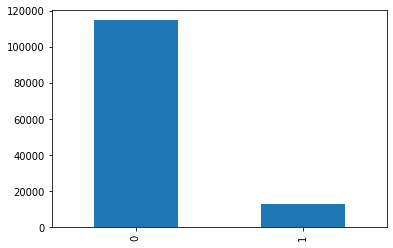

Target 1 / Target 0 ratio=11.30%


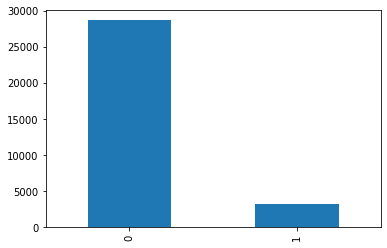

In [28]:
for sample in [train, test]:
    sample['toxic'].value_counts().plot(kind='bar')
    print(f"Target 1 / Target 0 ratio={sample['toxic'].value_counts()[1] / sample['toxic'].value_counts()[0]:.2%}")
    plt.show()

Пайплайн обучения моделей.
1) Векторизируем лемматизированый текст с помощью TfidfVectorizer;  
2) Используя RandomizedSearchCV со страцифицированной кросс-валидацией по трем фолдам найдем гиперпараметры моделей и параметры векторизации признаков с наибольшей метрикой F1.  

В качестве моделей используем LogisticRegression и LightGBM. Для них по умолчанию задаем гиперпараметр class_weight='balanced', так как в выбрке имеется дисбаланс целевого класса.  
При векторизации текста подберем параметр числа N-грамм ngram_range от одной до двух.   

Выделим тренировочный датасет для поиска гиперпараметров. Ранее добавленный признак 'caps_on' не будем использовать при поиске, используем его позже при тестировании моделей.

In [29]:
data = train[['lem_text', 'toxic']]

### LogisticRegression

In [30]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=12345)
lgr_pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('lgr', LogisticRegression(random_state=12345, class_weight='balanced')),
])

lgr_parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),  
    'lgr__solver': ('saga', 'liblinear'),
    'lgr__C': np.linspace(1.0, 51, num=11),
    'lgr__max_iter': (100, 200)
}

lgr_rand_search = RandomizedSearchCV(lgr_pipeline, lgr_parameters, n_jobs=-1, cv=cv, n_iter=6, scoring='f1', verbose=10)
lgr_rand_search.fit(data.lem_text, data.toxic)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=26.0 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=26.0, score=0.758, total=  39.8s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=26.0 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.8s remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=26.0, score=0.765, total=  37.9s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=26.0 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=26.0, score=0.757, total=  38.6s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=41.0 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=41.0, score=0.755, total=  41.5s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=41.0 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=41.0, score=0.759, total=  40.2s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=41.0 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=100, lgr__C=41.0, score=0.753, total=  38.9s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=16.0 


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.0min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=16.0, score=0.758, total=  34.2s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=16.0 


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  4.5min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=16.0, score=0.767, total=  29.7s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=16.0 


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  5.0min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=16.0, score=0.761, total=  28.5s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=11.0 


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  5.5min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=11.0, score=0.758, total=  26.1s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=11.0 
[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=11.0, score=0.768, total=  28.7s
[CV] vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=11.0 
[CV]  vect__ngram_range=(1, 1), lgr__solver=liblinear, lgr__max_iter=200, lgr__C=11.0, score=0.762, total=  26.4s
[CV] vect__ngram_range=(1, 1), lgr__solver=saga, lgr__max_iter=100, lgr__C=16.0 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  vect__ngram_range=(1, 1), lgr__solver=saga, lgr__max_iter=100, lgr__C=16.0, score=0.753, total=   9.7s
[CV] vect__ngram_range=(1, 1), lgr__solver=saga, lgr__max_iter=100, lgr__C=16.0 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  vect__ngram_range=(1, 1), lgr__solver=saga, lgr__max_iter=100, lgr__C=16.0, score=0.748, total=   9.3s
[CV] vect__ngram_range=(1, 1), lgr__solver=saga, lgr__max_iter=100, lgr__C=16.0 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  vect__ngram_range=(1, 1), lgr__solver=saga, lgr__max_iter=100, lgr__C=16.0, score=0.759, total=   9.5s
[CV] vect__ngram_range=(1, 2), lgr__solver=saga, lgr__max_iter=200, lgr__C=11.0 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  vect__ngram_range=(1, 2), lgr__solver=saga, lgr__max_iter=200, lgr__C=11.0, score=0.777, total=  56.8s
[CV] vect__ngram_range=(1, 2), lgr__solver=saga, lgr__max_iter=200, lgr__C=11.0 
[CV]  vect__ngram_range=(1, 2), lgr__solver=saga, lgr__max_iter=200, lgr__C=11.0, score=0.788, total=  53.8s
[CV] vect__ngram_range=(1, 2), lgr__solver=saga, lgr__max_iter=200, lgr__C=11.0 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  vect__ngram_range=(1, 2), lgr__solver=saga, lgr__max_iter=200, lgr__C=11.0, score=0.784, total= 1.0min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 10.2min finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=12345, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                 

In [31]:
print("Лучшее значение средней метрики F1 на кросс-валидации: %0.3f" % lgr_rand_search.best_score_)

Лучшее значение средней метрики F1 на кросс-валидации: 0.783


### LGBMClassifier

In [32]:
lgbm_pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('lgbm', LGBMClassifier(random_state=12345, class_weight='balanced')),
])

lgbm_parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),  
    'lgbm__num_leaves' : (31, 61),
    'lgbm__learning_rate' : np.linspace(0.15, 0.95, num=9),
    'lgbm__n_estimators' : (100, 200)
}

lgbm_rand_search = RandomizedSearchCV(lgbm_pipeline, lgbm_parameters, n_jobs=-1, cv=cv, n_iter=3, scoring='f1', verbose=10)
lgbm_rand_search.fit(data.lem_text, data.toxic)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] vect__ngram_range=(1, 1), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.15 
[CV]  vect__ngram_range=(1, 1), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.15, score=0.751, total= 7.0min
[CV] vect__ngram_range=(1, 1), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.15 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.0min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.15, score=0.759, total= 7.0min
[CV] vect__ngram_range=(1, 1), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.15 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 14.1min remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.15, score=0.753, total= 6.8min
[CV] vect__ngram_range=(1, 2), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.75 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 20.8min remaining:    0.0s


[CV]  vect__ngram_range=(1, 2), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.75, score=0.587, total= 8.7min


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 29.5min remaining:    0.0s


[CV] vect__ngram_range=(1, 2), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.75 
[CV]  vect__ngram_range=(1, 2), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.75, score=0.604, total= 8.6min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 38.1min remaining:    0.0s


[CV] vect__ngram_range=(1, 2), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.75 
[CV]  vect__ngram_range=(1, 2), lgbm__num_leaves=61, lgbm__n_estimators=200, lgbm__learning_rate=0.75, score=0.594, total=12.6min


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 50.8min remaining:    0.0s


[CV] vect__ngram_range=(1, 2), lgbm__num_leaves=31, lgbm__n_estimators=200, lgbm__learning_rate=0.6499999999999999 
[CV]  vect__ngram_range=(1, 2), lgbm__num_leaves=31, lgbm__n_estimators=200, lgbm__learning_rate=0.6499999999999999, score=0.697, total= 5.7min


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed: 56.4min remaining:    0.0s


[CV] vect__ngram_range=(1, 2), lgbm__num_leaves=31, lgbm__n_estimators=200, lgbm__learning_rate=0.6499999999999999 
[CV]  vect__ngram_range=(1, 2), lgbm__num_leaves=31, lgbm__n_estimators=200, lgbm__learning_rate=0.6499999999999999, score=0.688, total= 4.8min


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 61.3min remaining:    0.0s


[CV] vect__ngram_range=(1, 2), lgbm__num_leaves=31, lgbm__n_estimators=200, lgbm__learning_rate=0.6499999999999999 
[CV]  vect__ngram_range=(1, 2), lgbm__num_leaves=31, lgbm__n_estimators=200, lgbm__learning_rate=0.6499999999999999, score=0.677, total= 4.7min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 66.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 66.0min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=12345, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                 

In [33]:
print("Лучшее значение средней метрики F1 на кросс-валидации: %0.3f" % lgbm_rand_search.best_score_)

Лучшее значение средней метрики F1 на кросс-валидации: 0.754


Выведем лучшие параметры каждой модели.

In [34]:
print("LogisticRegressiom parameters:")
print(lgr_parameters)
print("Best F1-score : %0.3f" % lgr_rand_search.best_score_)
print("Best parameters set:")
lgr_best_parameters = lgr_rand_search.best_estimator_.get_params()
for param_name in sorted(lgr_parameters.keys()):
    print("\t%s: %r" % (param_name, lgr_best_parameters[param_name]))

LogisticRegressiom parameters:
{'vect__ngram_range': ((1, 1), (1, 2)), 'lgr__solver': ('saga', 'liblinear'), 'lgr__C': array([ 1.,  6., 11., 16., 21., 26., 31., 36., 41., 46., 51.]), 'lgr__max_iter': (100, 200)}
Best F1-score : 0.783
Best parameters set:
	lgr__C: 11.0
	lgr__max_iter: 200
	lgr__solver: 'saga'
	vect__ngram_range: (1, 2)


In [35]:
print("LGBM parameters:")
print(lgbm_parameters)
print("Best F1-score: %0.3f" % lgbm_rand_search.best_score_)
print("Best lgbm_parameters set:")
lgbm_best_parameters = lgbm_rand_search.best_estimator_.get_params()
for param_name in sorted(lgbm_parameters.keys()):
    print("\t%s: %r" % (param_name, lgbm_best_parameters[param_name]))

LGBM parameters:
{'vect__ngram_range': ((1, 1), (1, 2)), 'lgbm__num_leaves': (31, 61), 'lgbm__learning_rate': array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]), 'lgbm__n_estimators': (100, 200)}
Best F1-score: 0.754
Best lgbm_parameters set:
	lgbm__learning_rate: 0.15
	lgbm__n_estimators: 200
	lgbm__num_leaves: 61
	vect__ngram_range: (1, 1)


Для каждой модели число N-грамм может быть разное из-за радномного поиска параметров, поэтому зададим разные переменные векторизации для обоих моделей.

In [36]:
lgr_vectorizer = TfidfVectorizer(ngram_range=lgr_best_parameters['vect__ngram_range'])
lgbm_vectorizer = TfidfVectorizer(ngram_range=lgbm_best_parameters['vect__ngram_range'])

### Тестирование моделей

Получим векторы признаков tfidf для каждой модели. Для проверки выведем размерности матриц признаков.

Признаки для модели lgbm.

In [37]:
X_train_tfidf_lgbm = lgbm_vectorizer.fit_transform(train['lem_text'])
X_test_tfidf_lgbm = lgbm_vectorizer.transform(test['lem_text'])
print(X_train_tfidf_lgbm.shape, X_test_tfidf_lgbm.shape)

(127656, 178973) (31915, 178973)


Признаки для модели lgr.

In [38]:
X_train_tfidf_lgr = lgr_vectorizer.fit_transform(train['lem_text'])
X_test_tfidf_lgr = lgr_vectorizer.transform(test['lem_text'])
print(X_train_tfidf_lgr.shape, X_test_tfidf_lgr.shape)

(127656, 2046654) (31915, 2046654)


Не забываем про выделенный на этапе анализа данных призна caps_on, который будет положительным, если текст полностью написан в верхнем регистре. Добавим этот признак к полученным векторам и сохраним в отдельных переменных для тестирования. Признаков  станет на один больше.

Признаки для модели lgbm + признак caps_on.

In [39]:
X_train_full_lgbm = hstack((X_train_tfidf_lgbm, train[['caps_on']]))
X_test_full_lgbm = hstack((X_test_tfidf_lgbm, test[['caps_on']]))
print(X_train_full_lgbm.shape, X_test_full_lgbm.shape)

(127656, 178974) (31915, 178974)


Признаки для модели lgr + признак caps_on

In [40]:
X_train_full_lgr = hstack((X_train_tfidf_lgr, train[['caps_on']]))
X_test_full_lgr = hstack((X_test_tfidf_lgr, test[['caps_on']]))
print(X_train_full_lgr.shape, X_test_full_lgr.shape)

(127656, 2046655) (31915, 2046655)


Кастомный признак написания твита в верхнем регистре добавлен.

Проведем тестирование моделей.

Создадим список для записи F1-меры на тестовых данных и пройдем в цикле моделью логистической регрессии с лучшими параметрами по признакам TF-IDF (tfidf_lgr) и TF-IDF+caps_on (full_lgr).

In [41]:
result = []
for features_lgr in [[X_train_tfidf_lgr, X_test_tfidf_lgr], [X_train_full_lgr, X_test_full_lgr]]:
    model = lgr_rand_search.best_estimator_[1]
    model.fit(features_lgr[0], train['toxic'])
    pred = model.predict(features_lgr[1])
    f1 = f1_score(test['toxic'], pred)
    result.append(f1)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Аналогично с моделью LGBV.

In [42]:
for features_lgbm in [[X_train_tfidf_lgbm, X_test_tfidf_lgbm], [X_train_full_lgbm, X_test_full_lgbm]]:
    model = lgbm_rand_search.best_estimator_[1]
    model.fit(features_lgbm[0], train['toxic'])
    pred = model.predict(features_lgbm[1])
    f1 = f1_score(test['toxic'], pred)
    result.append(f1)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:546: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Сведем результаты в таблицу.

In [43]:
results = pd.DataFrame(
    result, columns=['f1_score'], index =[
        'LogisticRegression_TF_IDF', 'LogisticRegression_TF_IDF+add_feature', 'LGBM_TF_IDF', 'LGBM_TF_IDF+add_feature'])

In [44]:
results

,f1_score
LogisticRegression_TF_IDF,0.782084
LogisticRegression_TF_IDF+add_feature,0.787343
LGBM_TF_IDF,0.750424
LGBM_TF_IDF+add_feature,0.753554


- Обе модели на тестовых данных показали метрику F-1 выше 0,75;
- По результатам кросс-валидации F-1 мера для логистической регресии равна 0.783, а для LGBMClassifier 0,754;
- Логистическая регрессия имеет F-1 меру (0.787343) выше, чем LGBMClassifier (0.753554); 
- Учет признака написания текста только в верхнем регистре повышает метрику на несколько сотых в обеих моделях.  

## Выводы

На этапе предобработки данных выделен признак caps_on - написание текста только в верхнем регистре.
- символы разметки и сторонние символы, кроме буквенных удалены;
- текст переведен в нижний регистр;
- произведена лемматизация с удалением стоп-слов.

Кросс-валидацией для TF-IDF подобран размер N-грамм векторизации текста и гиперпараметры моделей LogisticRegression, LGBMClassifier.
- при кросс-валидации F-1 мера для LogisticRegression равна 0,783, а для LGBMClassifier 0,754. На тестовых 0,787343 и 0,753554, соответственно;
- учет признака caps_on положительно сказался на метрике всех моделей;
- модели на тестовых данных показали метрику F-1 выше необходимого значения 0.75, следовательно полученные модели позволяют искать токсичные комментарии.

